In [2]:
# Helper libraries
import datetime
from packaging import version
import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.datasets import mnist
from tensorflow.keras import backend as K

In [3]:
%matplotlib inline
np.set_printoptions(precision=3, suppress=True)

In [4]:
print("This notebook requires TensorFlow 2.0 or above")
print("TensorFlow version: ", tf.__version__)
assert version.parse(tf.__version__).release[0] >=2

This notebook requires TensorFlow 2.0 or above
TensorFlow version:  2.3.0


In [5]:
print("Keras version: ", keras.__version__)

Keras version:  2.4.0


In [6]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

In [7]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [8]:
original_dim = 28 * 28
intermediate_dim = 64
latent_dim = 2

inputs = keras.Input(shape=(original_dim,))
h = layers.Dense(intermediate_dim, activation='relu')(inputs)
z_mean = layers.Dense(latent_dim)(h)
z_log_sigma = layers.Dense(latent_dim)(h)

In [9]:
def sampling(args):
    z_mean, z_log_sigma = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim),
                              mean=0., stddev=0.1)
    return z_mean + K.exp(z_log_sigma) * epsilon

z = layers.Lambda(sampling)([z_mean, z_log_sigma])

In [10]:
# Create encoder
encoder = keras.Model(inputs, [z_mean, z_log_sigma, z], name='encoder')

# Create decoder
latent_inputs = keras.Input(shape=(latent_dim,), name='z_sampling')
x = layers.Dense(intermediate_dim, activation='relu')(latent_inputs)
outputs = layers.Dense(original_dim, activation='sigmoid')(x)
decoder = keras.Model(latent_inputs, outputs, name='decoder')

# instantiate VAE model
outputs = decoder(encoder(inputs)[2])
vae = keras.Model(inputs, outputs, name='vae_mlp')

In [11]:
vae.summary()

Model: "vae_mlp"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
encoder (Functional)         [(None, 2), (None, 2), (N 50500     
_________________________________________________________________
decoder (Functional)         (None, 784)               51152     
Total params: 101,652
Trainable params: 101,652
Non-trainable params: 0
_________________________________________________________________


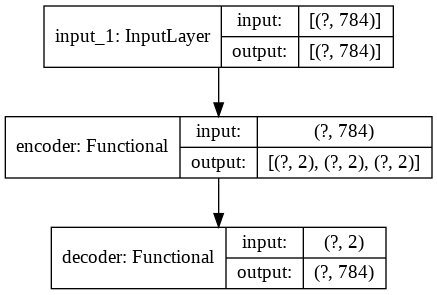

In [12]:
keras.utils.plot_model(vae, "EncoderModel.png", show_shapes=True)

In [13]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


In [14]:

reconstruction_loss = keras.losses.binary_crossentropy(inputs, outputs)
reconstruction_loss *= original_dim
kl_loss = 1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')

In [15]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

In [16]:
history = vae.fit(x_train, x_train,
            epochs=100,
            batch_size=32,
            validation_data=(x_test, x_test))

Epoch 1/100
1875/1875 [==============================] - 5s 3ms/step - loss: 186.2507 - val_loss: 167.0795
Epoch 2/100
1875/1875 [==============================] - 5s 3ms/step - loss: 165.6685 - val_loss: 162.9609
Epoch 3/100
1875/1875 [==============================] - 5s 3ms/step - loss: 162.7144 - val_loss: 160.7380
Epoch 4/100
1875/1875 [==============================] - 5s 3ms/step - loss: 160.5818 - val_loss: 159.0266
Epoch 5/100
1875/1875 [==============================] - 5s 3ms/step - loss: 159.0295 - val_loss: 157.6936
Epoch 6/100
1875/1875 [==============================] - 5s 3ms/step - loss: 157.9055 - val_loss: 156.6713
Epoch 7/100
1875/1875 [==============================] - 5s 3ms/step - loss: 156.9618 - val_loss: 155.8268
Epoch 8/100
1875/1875 [==============================] - 5s 3ms/step - loss: 156.1773 - val_loss: 155.4187
Epoch 9/100
1875/1875 [==============================] - 5s 3ms/step - loss: 155.5034 - val_loss: 154.5533
Epoch 10/100
1875/1875 [=============

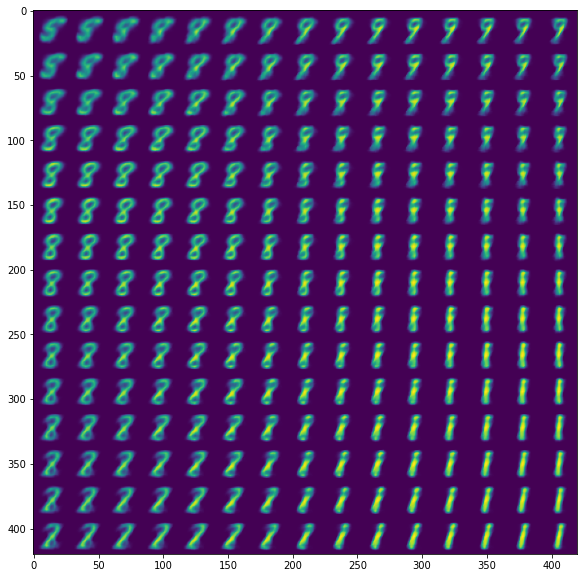

In [17]:
# Display a 2D manifold of the digits
n = 15  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
grid_x = np.linspace(0.05, 0.95, n)
grid_y = np.linspace(0.05, 0.95, n)

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure)
plt.show()

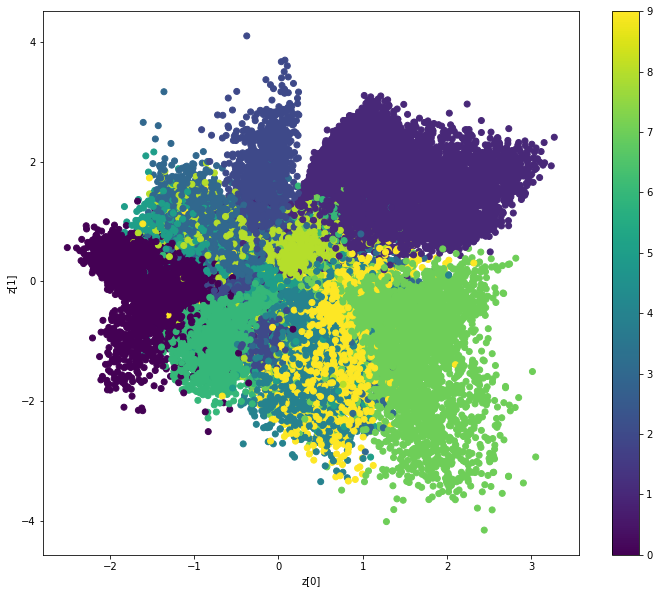

In [18]:
def plot_label_clusters(encoder, decoder, data, labels):
    # display a 2D plot of the digit classes in the latent space
    z_mean, _, _ = encoder.predict(data)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=labels)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.show()

plot_label_clusters(encoder, decoder, x_train, y_train)

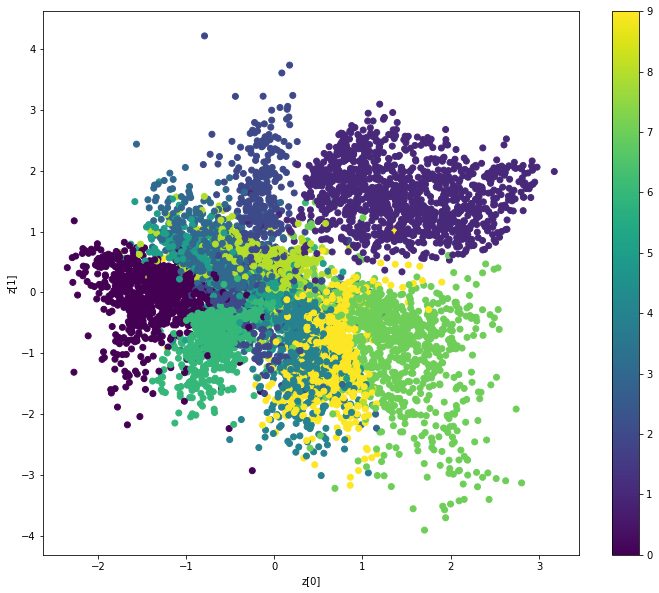

In [19]:

plot_label_clusters(encoder, decoder, x_test, y_test)

In [20]:
original_dim = 28 * 28
intermediate_dim = 16
latent_dim = 2

inputs = keras.Input(shape=(original_dim,))
h = layers.Dense(intermediate_dim, activation='relu')(inputs)
z_mean = layers.Dense(latent_dim)(h)
z_log_sigma = layers.Dense(latent_dim)(h)

In [21]:
def sampling(args):
    z_mean, z_log_sigma = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim),
                              mean=0., stddev=0.1)
    return z_mean + K.exp(z_log_sigma) * epsilon

z = layers.Lambda(sampling)([z_mean, z_log_sigma])

In [22]:
# Create encoder
encoder = keras.Model(inputs, [z_mean, z_log_sigma, z], name='encoder')

# Create decoder
latent_inputs = keras.Input(shape=(latent_dim,), name='z_sampling')
x = layers.Dense(intermediate_dim, activation='relu')(latent_inputs)
outputs = layers.Dense(original_dim, activation='sigmoid')(x)
decoder = keras.Model(latent_inputs, outputs, name='decoder')

# instantiate VAE model
outputs = decoder(encoder(inputs)[2])
vae = keras.Model(inputs, outputs, name='vae_mlp')

In [23]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

In [32]:
print('x_train:\t{}'.format(x_train.shape))
print('y_train:\t{}'.format(y_train.shape))
print('x_test:\t\t{}'.format(x_test.shape))
print('y_test:\t\t{}'.format(y_test.shape))

x_train:	(60000, 784)
y_train:	(60000,)
x_test:		(10000, 784)
y_test:		(10000,)


In [33]:
print("First ten labels training dataset:\n {}\n".format(y_train[0:10]))

First ten labels training dataset:
 [5 0 4 1 9 2 1 3 1 4]



In [34]:
Counter(y_train).most_common()

[(1, 6742),
 (7, 6265),
 (3, 6131),
 (2, 5958),
 (9, 5949),
 (0, 5923),
 (6, 5918),
 (8, 5851),
 (4, 5842),
 (5, 5421)]

In [35]:
Counter(y_test).most_common()

[(1, 1135),
 (2, 1032),
 (7, 1028),
 (3, 1010),
 (9, 1009),
 (4, 982),
 (0, 980),
 (8, 974),
 (6, 958),
 (5, 892)]

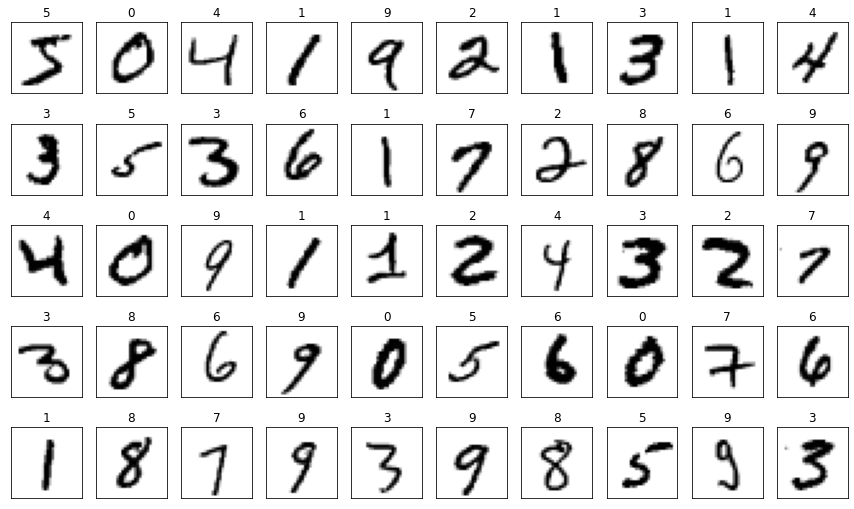

In [36]:
fig = plt.figure(figsize = (15, 9))

for i in range(50):
    plt.subplot(5, 10, 1+i)
    plt.title(y_train[i])
    plt.xticks([])
    plt.yticks([])
    plt.imshow(x_train[i].reshape(28,28), cmap='binary')

In [24]:
reconstruction_loss = keras.losses.binary_crossentropy(inputs, outputs)
reconstruction_loss *= original_dim
kl_loss = 1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')

In [25]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

In [26]:
history = vae.fit(x_train, x_train,
            epochs=100,
            batch_size=32,
            validation_data=(x_test, x_test))

Epoch 1/100
1875/1875 [==============================] - 5s 3ms/step - loss: 213.5371 - val_loss: 192.4898
Epoch 2/100
1875/1875 [==============================] - 5s 3ms/step - loss: 176.7595 - val_loss: 169.6621
Epoch 3/100
1875/1875 [==============================] - 5s 3ms/step - loss: 168.3963 - val_loss: 166.8058
Epoch 4/100
1875/1875 [==============================] - 5s 3ms/step - loss: 166.1436 - val_loss: 165.5243
Epoch 5/100
1875/1875 [==============================] - 5s 3ms/step - loss: 164.8932 - val_loss: 164.3810
Epoch 6/100
1875/1875 [==============================] - 5s 3ms/step - loss: 163.9971 - val_loss: 163.6165
Epoch 7/100
1875/1875 [==============================] - 5s 3ms/step - loss: 163.2380 - val_loss: 162.9973
Epoch 8/100
1875/1875 [==============================] - 5s 3ms/step - loss: 162.6047 - val_loss: 162.3633
Epoch 9/100
1875/1875 [==============================] - 5s 3ms/step - loss: 162.0497 - val_loss: 162.0303
Epoch 10/100
1875/1875 [=============

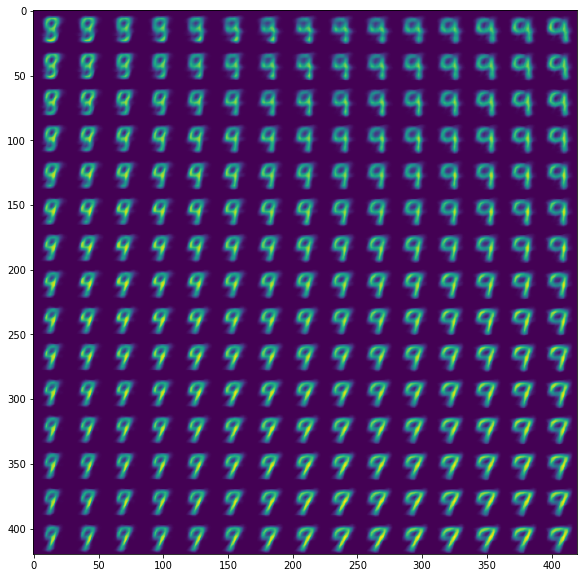

In [27]:
# Display a 2D manifold of the digits
n = 15  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
grid_x = np.linspace(0.05, 0.95, n)
grid_y = np.linspace(0.05, 0.95, n)

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure)
plt.show()

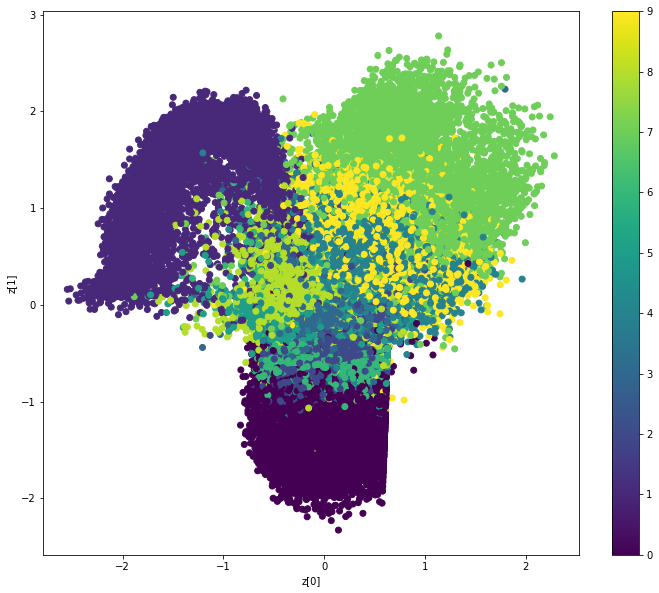

In [28]:


plot_label_clusters(encoder, decoder, x_train, y_train)

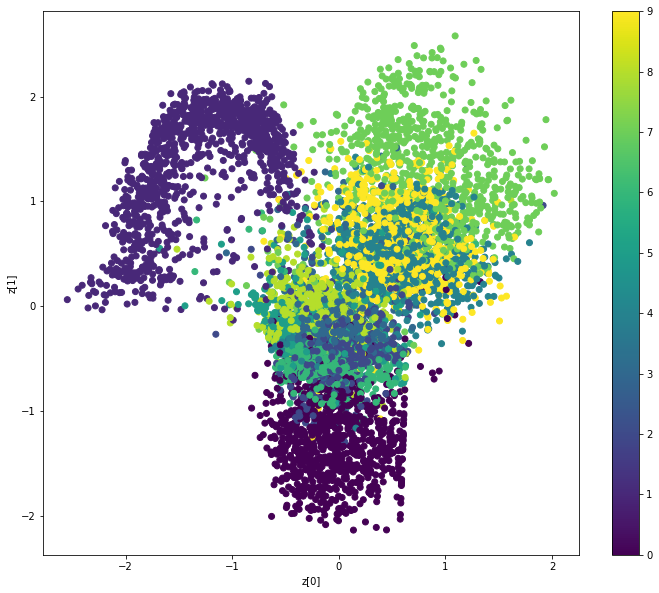

In [29]:


plot_label_clusters(encoder, decoder, x_test, y_test)